### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Add the downloaded notebook (.ipynb file) to the submission zip**.

Make sure you fill in any place that says `YOUR CODE HERE` or "**WRITE YOUR ANSWER IN THIS CELL**", and that no tests fail.  
Write the IDs of all group members in the cell below. Leave any surplus IDs as `""`.

ID1 = ""  
ID2 = ""  


---

![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous two sections we dealt with word-level language models. But looking again at section 2, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 2 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 3.a
Can you think of an advantage a character-based language model could have over a word-based language model? _(You might find question 2.c useful)_. And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model?

**WRITE YOUR ANSWER IN THIS CELL**


### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [82]:
import string
import random
import re

import unidecode

all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(open('data/shakespeare.txt').read())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


To make inputs out of this big string of text, we will split it into chunks.

In [83]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())

I were hanged,
but I thought there was more in him than I could think.

Second Servingman:
So did I, I'll be sworn: he is simply the rarest
man i' the world.

First Servingman:
I think he is: but a greater soldier than he you wot on.

Second Servingman:
Who, my master?

First Servingman:
Nay, it's no matter for that.

Second Servingman:
Worth six on him.

First Servingman:
Nay, not so neither: but 


### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\] 

### Question 3.b
Complete the implementation of the `forward` method of our model.

In [99]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        if len(input_.shape) == 0:
            input_ = input_.unsqueeze(0)
        emb = self.embedding(input_)
        emb = emb.unsqueeze(0)
        out, hidden = self.gru(emb, hidden)
        output = self.output_layer(out)
        output = output.squeeze(0)
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [85]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Each training example for our model will be created from a chunk randomly extracted from our shakespeare dataset. For example, if we set our chunk size to be 28, then a randomly extracted chunk could be $\texttt{As deep as that, though true}$. Each training example is of a form $(\textbf{x},\textbf{y})$ where $\textbf{x}$ is all the charecters of the chunk *except the last* and $\textbf{y}$ is all the charecters of the chunk *except the first*. For example, given the chunk above, $\textbf{x}=\texttt{As deep as that, though tru}$ and $\textbf{y}=\texttt{s deep as that, though true}$. At timestep i our input is $\textbf{x}^{(i)}$ and the gold label our model will try to predict is $\textbf{y}^{(i)}$.

In [86]:
def random_training_example():    
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [87]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

### Training

The main training function

In [88]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [89]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [90]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [100]:
n_iterations = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for iteration in range(1, n_iterations + 1):
    loss = train(*random_training_example())       
    loss_avg += loss

    if iteration % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  iterations: {iteration} ({iteration / n_iterations * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if iteration % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 31s  ;  iterations: 100 (5.0%)  ;  loss: 2.07]
Whoun
Fot nod nond foromoks incril aut wist to an
The ry sente ond the thas the mon and he hiler this youe,
Fast he bem dole to tot, he this thae the or wusest ore seros, houll wist dan thathen I stin w 

[time elapsed: 1m 5s  ;  iterations: 200 (10.0%)  ;  loss: 2.04]
Whef econ Lor on of the foor now the you rdesal the the net,
And need thaind thew not men ies that for hadess a have fore.

COLUSETRE:
Difich this dooford is for winsours thims thous for have hou the ba 

[time elapsed: 1m 39s  ;  iterations: 300 (15.0%)  ;  loss: 1.885]
What beafep thead he dencer's hat the pricion
Tighter liest his mone as
weth me maque listowid lovledsunas solmave
for and was wor,
The dop to ham elling betere have This shard.

LING EDWWARD IVI:
And h 

[time elapsed: 2m 13s  ;  iterations: 400 (20.0%)  ;  loss: 1.923]
WhWizees but sould ture the sess;
How, and in bid stit inder and thy herece so dis offithing:
De wit. Whem to sew,
Bist, 

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning.

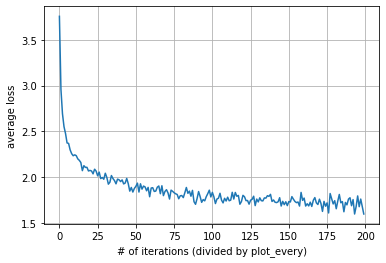

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of iterations (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

### Evaluating at Different Temperatures
Every time we use the `evaluate` function to generate the distribution of the next character, we don't just use softmax as usual, but we also divide by a `temperature`.  
Let's examine the effect of changing the temperature when generating text using our trained model:

In [102]:
print(evaluate('Th', 400, temperature=0.1))

There the with the with the shall the with the with the with the with the shall the with the shall the with the so the with the do the with the with the so the shall the with the with the will down the will the with the shall the with the will the will the with the shall be the will the with the see the with the will the with the with the shall the with the will doth the with the down the with the s


In [103]:
print(evaluate('Th', 400, temperature=0.5))

Thou with his the rest so I will shall sounding you doth done our the waing the shall prosent and the come the one the serve
To with shall hast shall be the shall shall the will die hath the one a hange the sently
Than see a so shall see the the so the there a word
And shall the done the priest thus sence, so pition he the the lord.

PRINCET:
I do be his so this in could the rease of so die
And with


In [104]:
print(evaluate('Th', 400, temperature=0.8))  # the default value

Thoold:
Dout will things all a and the fain blood.

PETRUCHIO:
Who I have by it and wifes their had conters.

ISTAR:
From must know good hate so die or so,
This I'll brother, in king his for thing the know offorl.

PROTER:
Come,
As boat, in master!

PROSPERO:
Where? be a have the wish had by him:
Whis for the go hered thou do pay, pened that and he not sever parden,
Fid I love and he revend the not 


In [105]:
print(evaluate('Th', 400, temperature=1))

The state; and than raige the pearige;
Ene thanks; wo garleces he would noth reconfed
mepie the peharre of to not a well but sir? That is I it's gend
Urou, we bid of a supkn, wauk, fier thy rectiou.

Procot, he love.

PROSHA:
Ay it whessellied I hese is the beither's I who's
ned of a not well you preny thes clow.

PROS ERCINCUTIO:
And shall within wan: with molain.

First Yore or hath jow shac that 


In [106]:
print(evaluate('Th', 400, temperature=1.5))

Thishady yold? lome
whereidy the allasty sept can! VI
Lomen Duke billl chatiuly noll maviol mean Enhl.

BRUTUVO:
MP, fould lIn we'd neve him, but Ifame be ime thee:
Ofrew. Wherumicion, knweals dids thicious to hul remenmangand
tatted,-bork dithet; if alate! 'tnot Earl:
And in pridand tyrele yago! Jothing!
Righil itt werem, we Ou raid drumfauty. O upodvell.

Hy:
Soibt, Lellenselesmerx'd.

PROSTONPE:


### Question 3.c
How does the value of `temperature` affect the properties of the generated text?
Specifically address the process of sampling a character from the next character distribution, and the effect `temperature` has on it.

**WRITE YOUR ANSWER IN THIS CELL**
As we can see, as the temperature going far from the default value (0.8) the sentences become less logical and reasonable.